In [294]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

## File Loading

In [344]:
#File di info su PoI
poi_info_csv = "C:\\Users\\alfon\\Documents\\Master\\Progettone\\data_preparation\\reviews_csv\\output\\poi_info.csv"
df_poi = pd.read_csv(poi_info_csv, delimiter=',', encoding='utf-8', skipinitialspace=True)

#File delle recensioni
reviews_3_distinct_poi = "C:\\Users\\alfon\\Documents\\Master\\Progettone\\data_preparation\\reviews_csv\\output\\reviews_3_distinct_poi.csv"
df_reviews = pd.read_csv(reviews_3_distinct_poi, delimiter=',', quotechar='|', encoding='utf-8', skipinitialspace=True)

#Mappping dei Rating
rating_dict={1: -2,
             2: -1,
             3: 0,
             4: 1,
             5: 2
}
df_reviews['rating'] = df_reviews['rating'].map(rating_dict)

#File delle liste invertite user-category (conteggio delle recesioni di PoI distinti in ciascuna categoria per utente)
inv_user_category_count_csv = "C:\\Users\\alfon\\Documents\\Master\\Progettone\\data_preparation\\reviews_csv\\output\\inv_user_category_count.csv"
df_inv_cat = pd.read_csv(inv_user_category_count_csv, delimiter=',', quotechar='"', encoding='utf-8', skipinitialspace=True)
df_inv_cat = df_inv_cat.set_index('user')

cat_columns = df_inv_cat.columns

## Define Tourist Interest for each Category

In [345]:
tourist1 = np.array([5,3,5,1,3,1,3,1,2])
tourist2 = np.array([1,2,1,3,3,4,2,5,5])
tourist3 = np.array([3,2,1,2,2,5,5,3,3])
tourist = tourist1
df_tourist = pd.DataFrame(tourist, columns=['interest'])
df_tourist['category'] = cat_columns
df_tourist

,interest,category
0,5,Architecture
1,3,Art-Culture
2,5,Churches-Religious Sites
3,1,Entertainment
4,3,History
5,1,Monuments-Statue
6,3,Museums
7,1,Nature
8,2,Walking Areas


## Calculate mean rating weighted by similarity tourist-user

In [346]:
scaler = MinMaxScaler()

#df_user_sim
#dataframe contente per ogni utente la cosine similarity con il turista
df_user_sim = pd.DataFrame()
df_user_sim['user'] = df_inv_cat.index
df_user_sim['sim'] = cosine_similarity(df_tourist['interest'].values.reshape(1, -1), df_inv_cat)[0]

#df_sim_rating
#dataframe contente per ogni PoI:
#sim = la media della similarità degli degli utenti che hanno recensito il PoI
#rating = la media dei rating attribuiti dagli utenti che hanno recensito il PoI
#sim_rating = la media "pesata" del rating attribuiti dagli utenti, dove il peso è lo score di similarità dell'utente
df_sim_rating = df_reviews[['poi_id','user', 'rating']].copy()
df_sim_rating = df_sim_rating.merge(df_user_sim, on='user')
df_sim_rating['sim_rating'] = df_sim_rating['sim']*df_sim_rating['rating']
df_sim_rating = df_sim_rating.pivot_table(index='poi_id', values=['sim','rating', 'sim_rating'], aggfunc='mean' )
df_sim_rating = df_sim_rating.reset_index()
df_sim_rating = df_sim_rating.merge(df_poi[['poi_id', 'category_1']], on='poi_id')
df_sim_rating = df_sim_rating.merge(df_tourist, left_on='category_1', right_on='category').drop(['category', 'category_1'], axis=1)
df_sim_rating['interest'] = df_sim_rating['interest']/5

#df_poi_rank: merge di df_sim_rating con df_poi
df_poi_rank = df_poi[['poi_id', 'name', 'zone', 'actual_n_reviews', 'duration_num',
                      'lat', 'long', 'category_1', 'category_2']].merge(
                    df_sim_rating, on='poi_id').sort_values(by='sim_rating', ascending=False)
df_poi_rank['popularity'] = scaler.fit_transform(np.log2(df_poi_rank['actual_n_reviews']).values.reshape(-1, 1))

In [347]:
#Metodo 1
#Rank dato dalla media pesate dei rating e similarità con l'aggiunta di popolarità
rat1 = 1
pop1 = 0.2 #0.2
df_poi_rank['rank_1'] = rat1*df_poi_rank['sim_rating'] + pop1*df_poi_rank['popularity']

In [348]:
#Metodo 2
#Rank dato da una combinazione lineare delle 4 variabili: rating, similarità, interesse e popolarità
rat2 = 1
sim = 1
inte = 0.3
pop2 = 0.2 #0.2
df_poi_rank['rank_2'] = rat2*df_poi_rank['rating'] +sim*df_poi_rank['sim'] + inte*df_poi_rank['interest'] + pop2*df_poi_rank['popularity']

In [349]:
df_poi_rank_sel1 = df_poi_rank.sort_values(by='rank_1', ascending=False).iloc[:30]
df_poi_rank_sel1

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,3.030953
287,d7390600,Museo Di Sant'Eustorgio,Ticinese,23,2.50,45.454067,9.180958,Museums,Churches-Religious Sites,1.695652,0.807145,1.375180,0.6,0.328429,1.440866,2.748483
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,2.925928
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320,2.832663
291,d6686075,Fonderia Napoleonica Eugenia,Zone 9,18,2.50,45.493279,9.187848,Museums,History,1.666667,0.806420,1.325398,0.6,0.302753,1.385949,2.713638
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,2.770886
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,2.852129
1,d314197,Il Cenacolo,Centro Storico,5066,1.50,45.466307,9.170647,Art-Culture,Museums,1.701737,0.694777,1.186238,0.6,0.893511,1.364940,2.755216
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2.796376
71,d1905650,Palazzo Castiglioni,Centro Storico,47,0.25,45.471128,9.201379,Architecture,Museums,1.510638,0.847672,1.276698,1.0,0.403285,1.357355,2.738968


In [350]:
df_poi_rank_sel2 = df_poi_rank.sort_values(by='rank_2', ascending=False).iloc[:30]
df_poi_rank_sel2

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,3.030953
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,2.925928
0,d195239,Duomo di Milano,Centro Storico,14002,2.50,45.464098,9.191926,Churches-Religious Sites,Architecture,1.737537,0.663049,1.153392,1.0,1.000000,1.353392,2.900587
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,2.852129
16,d246678,Chiesa di Santa Maria presso San Satiro,Centro Storico,1116,0.75,45.462778,9.187778,Churches-Religious Sites,Architecture,1.668459,0.723373,1.205235,1.0,0.735052,1.352245,2.838842
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320,2.832663
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2.796376
14,d591187,Basilica di Sant'Ambrogio,Centro Storico,1889,2.50,45.462329,9.175612,Churches-Religious Sites,Architecture,1.619375,0.717770,1.165187,1.0,0.790179,1.323223,2.795181
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,2.770886
28,d591213,Certosa di Milano,Zone 8,213,1.50,45.502373,9.129558,Churches-Religious Sites,Art-Culture,1.596244,0.757058,1.207079,1.0,0.561571,1.319393,2.765617


In [351]:
df_poi_rank_sel1['category_1'].value_counts()

Churches-Religious Sites    9
Architecture                9
Museums                     5
Art-Culture                 3
History                     2
Monuments-Statue            1
Walking Areas               1
Name: category_1, dtype: int64

In [352]:
df_poi_rank_sel2['category_1'].value_counts()

Churches-Religious Sites    15
Architecture                 8
Museums                      3
Art-Culture                  3
History                      1
Name: category_1, dtype: int64

In [353]:
df_tourist

,interest,category
0,5,Architecture
1,3,Art-Culture
2,5,Churches-Religious Sites
3,1,Entertainment
4,3,History
5,1,Monuments-Statue
6,3,Museums
7,1,Nature
8,2,Walking Areas


## Cluster on Map

In [354]:
from geopy import distance
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import folium
from folium.plugins import MarkerCluster

In [355]:
coord1 = df_poi_rank_sel1.set_index('poi_id')[['lat', 'long']]
coord2 = df_poi_rank_sel2.set_index('poi_id')[['lat', 'long']]

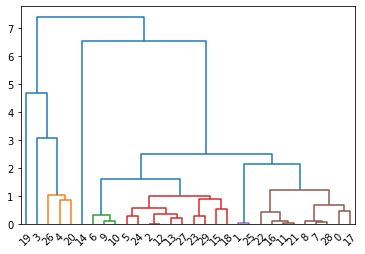

In [356]:
threshold = 1.5
data_link = linkage(coord1, method='complete', metric=lambda u,v: distance.distance(u,v).km)
labels = fcluster(data_link, t=threshold, criterion='distance')
df_poi_rank_sel1['label_hier'] = labels
res = dendrogram(data_link, color_threshold=threshold, truncate_mode='lastp')

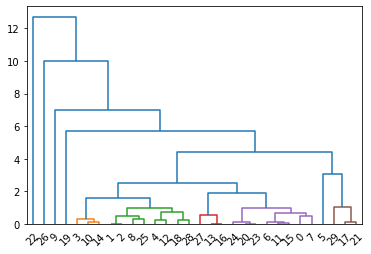

In [357]:
threshold = 1.5
data_link = linkage(coord2, method='complete', metric=lambda u,v: distance.distance(u,v).km)
labels = fcluster(data_link, t=threshold, criterion='distance')
df_poi_rank_sel2['label_hier'] = labels
res = dendrogram(data_link, color_threshold=threshold, truncate_mode='lastp')

In [358]:
map1 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label,poi_id in zip(df_poi_rank_sel1['lat'],df_poi_rank_sel1['long'],df_poi_rank_sel1['name'],df_poi_rank_sel1['label_hier'], df_poi_rank_sel1['poi_id']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name + ' ' + poi_id)),icon=folium.Icon(color=colori[label],icon_color='white')))
map1.add_child(fg)
map1

In [359]:
map2 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label in zip(df_poi_rank_sel2['lat'],df_poi_rank_sel2['long'],df_poi_rank_sel2['name'],df_poi_rank_sel2['label_hier']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name)),icon=folium.Icon(color=colori[label],icon_color='white')))
map2.add_child(fg)
map2

## Clustering gerarchico sul tempo

In [326]:
from scipy.spatial.distance import pdist, squareform

coord1 = df_poi_rank_sel1.set_index('poi_id')[['lat', 'long']]
coord2 = df_poi_rank_sel2.set_index('poi_id')[['lat', 'long']]

duration = df_poi_rank_sel1['duration_num'].values.reshape(-1,1)

space_dist = pdist(coord1, metric = lambda u,v: distance.distance(u,v).km)
time_dist = pdist(duration, metric = lambda u,v: abs(u-v)/3.50)
tot_dist = space_dist + (1 - time_dist)

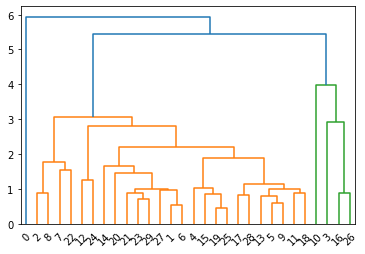

In [327]:
threshold = 1
data_link = linkage(tot_dist, method='average')
#labels = fcluster(data_link, t=threshold, criterion='distance')
#df_poi_rank_sel1['label_hier'] = labels
res = dendrogram(data_link)

In [328]:
#new_col = np.zeros((len(data_link),1))
#data_link_new = np.hstack((data_link, new_col))
data_link_new = data_link
for i in range(len(data_link)):
    length = len(duration)
    j = int(data_link[i][0])
    k = int(data_link[i][1])
    j_cluster = None
    k_cluster = None
    if j >= length:
        j_cluster = j - length
    if k >= length:
        k_cluster = k - length
    
    if j_cluster is None and k_cluster is None:
        duration_sum = duration[j][0] + duration[k][0]
        data_link_new[i][2] = duration_sum
    elif j_cluster is None and k_cluster is not None:
        duration_sum = duration[j][0] + data_link_new[k_cluster][2]
        data_link_new[i][2] = duration_sum
    elif j_cluster is not None and k_cluster is None:
        duration_sum = data_link_new[j_cluster][2] + duration[k][0]
        data_link_new[i][2] = duration_sum
    elif j_cluster is not None and k_cluster is not None:
        duration_sum = data_link_new[j_cluster][2] + data_link_new[k_cluster][2]
        data_link_new[i][2] = duration_sum

data_link_new

array([[19.  , 25.  ,  3.75,  2.  ],
       [ 1.  ,  6.  ,  3.  ,  2.  ],
       [ 5.  ,  9.  ,  3.25,  2.  ],
       [23.  , 29.  ,  4.  ,  2.  ],
       [13.  , 32.  ,  4.75,  3.  ],
       [17.  , 28.  ,  3.75,  2.  ],
       [15.  , 30.  ,  5.25,  3.  ],
       [21.  , 33.  ,  6.5 ,  3.  ],
       [11.  , 18.  ,  1.75,  2.  ],
       [ 2.  ,  8.  ,  1.75,  2.  ],
       [16.  , 26.  ,  2.75,  2.  ],
       [27.  , 31.  ,  5.5 ,  3.  ],
       [37.  , 41.  , 12.  ,  6.  ],
       [34.  , 38.  ,  6.5 ,  5.  ],
       [ 4.  , 36.  ,  7.75,  4.  ],
       [35.  , 43.  , 10.25,  7.  ],
       [12.  , 24.  ,  4.  ,  2.  ],
       [20.  , 42.  , 13.5 ,  7.  ],
       [ 7.  , 22.  ,  3.25,  2.  ],
       [14.  , 47.  , 15.  ,  8.  ],
       [39.  , 48.  ,  5.  ,  4.  ],
       [44.  , 45.  , 18.  , 11.  ],
       [49.  , 51.  , 33.  , 19.  ],
       [46.  , 52.  , 37.  , 21.  ],
       [ 3.  , 40.  ,  3.  ,  3.  ],
       [50.  , 53.  , 42.  , 25.  ],
       [10.  , 54.  ,  4.5 ,  4.  ],
 

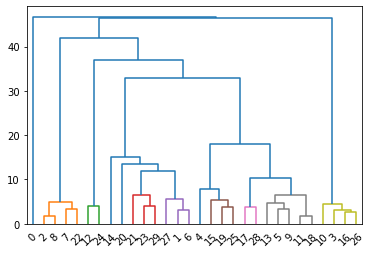

In [329]:
labels = fcluster(data_link, t=6, criterion='distance')
df_poi_rank_sel1['label_hier'] = labels
res = dendrogram(data_link, color_threshold=7, truncate_mode='lastp')

In [330]:
map1 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label,dur in zip(df_poi_rank_sel1['lat'],df_poi_rank_sel1['long'],df_poi_rank_sel1['name'],df_poi_rank_sel1['label_hier'], df_poi_rank_sel1['duration_num']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name + ' ' + str(dur))),icon=folium.Icon(color=colori[label],icon_color='white')))
map1.add_child(fg)
map1

## "Clustering" sul tempo (Non gerarchico)

In [360]:
duration = df_poi_rank_sel1['duration_num'].values.reshape(-1,1)

coord1 = df_poi_rank_sel1.set_index('poi_id')[['lat', 'long']]
coord2 = df_poi_rank_sel2.set_index('poi_id')[['lat', 'long']]

from scipy.spatial.distance import pdist, squareform

space_dist = pdist(coord1, metric = lambda u,v: distance.distance(u,v).km)
time_dist = pdist(duration, metric = lambda u,v: abs(u-v)/3.50)
#tot_dist = space_dist + (1 - time_dist)

space_dist = squareform(space_dist)
time_dist = squareform(time_dist)

In [332]:
coda = np.arange(len(df_poi_rank_sel1))
clusters = []
soglia = 5
while coda.size != 0:
    i = coda[0]
    print(i)
    cluster = [i]
    flat_clusters = [item for sublist in clusters for item in sublist]
    #print('flat_clusters simple:' , flat_clusters)
    flat_clusters.append(i)
    #print('flat_clusters append:' , flat_clusters)
    flat_clusters = np.array(flat_clusters)
    #print('flat_clusters numpy:' , flat_clusters)
    idx = np.argwhere(space_dist[i] < 1).reshape(-1)
    #print('idx:', idx)
    idx_new = np.setdiff1d(idx, flat_clusters)
    #print('idx_new:', idx_new)
    sum_duration = duration[i][0]
    while idx_new.size != 0:
        idx = idx_new
        #print('idx_new:', idx_new)
        #mean_time_dist = np.mean(time_dist[idx_new][:, cluster], axis = 1)
        #idx_ord = np.argsort(mean_time_dist)[::-1]
        mean_dist = np.mean(space_dist[idx_new][:, cluster], axis = 1)
        idx_ord = np.argsort(mean_dist)
        #print('idx_ord:', idx_ord)
        for j in idx_ord:
            sum_duration += duration[idx[j]][0]
            if sum_duration >= soglia:
                sum_duration -= duration[idx[j]][0]
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                continue
            else:
                cluster.append(idx[j])
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                break
        #print('cluster:', cluster)
        #print('sum_duration:', sum_duration)
    coda = np.setdiff1d(coda, cluster)
    clusters.append(cluster)

0
flat_clusters simple: []
flat_clusters append: [0]
flat_clusters numpy: [0]
idx: [0]
idx_new: []
1
flat_clusters simple: [0]
flat_clusters append: [0, 1]
flat_clusters numpy: [0 1]
idx: [ 1  2  3  5  6  7  8  9 11 13 14 15 17 18 20 21 23 27 28 29]
idx_new: [ 2  3  5  6  7  8  9 11 13 14 15 17 18 20 21 23 27 28 29]
idx_new: [ 2  3  5  6  7  8  9 11 13 14 15 17 18 20 21 23 27 28 29]
idx_ord: [ 3 16 14 18 15 13 11  9 17 12  7  6  5  8  2  4  0  1 10]
cluster: [1, 6]
sum_duration: 3.0
idx_new: [ 2  3  5  7  8  9 11 13 14 15 17 18 20 21 23 27 28 29]
idx_ord: [15 13 17 14 12 10  8 16 11  6  5  7  2  4  3  0  9  1]
cluster: [1, 6, 29]
sum_duration: 4.5
idx_new: [ 2  3  5  7  8  9 11 13 14 15 17 18 20 23 28]
idx_ord: [13 12 10  8 14 11  6  5  2  7  4  3  9  0  1]
cluster: [1, 6, 29, 28]
sum_duration: 4.75
idx_new: [ 2  3  5  7  8  9 11 13 15 18]
idx_ord: [9 6 5 2 7 8 4 0 3 1]
cluster: [1, 6, 29, 28]
sum_duration: 4.75
2
flat_clusters simple: [0, 1, 6, 29, 28]
flat_clusters append: [0, 1, 6, 

In [80]:
coda = np.arange(len(df_poi_rank_sel1))
clusters = []
soglia = 6
while coda.size != 0:
    i = coda[0]
    print(i)
    cluster = [i]
    flat_clusters = [item for sublist in clusters for item in sublist]
    print('flat_clusters simple:' , flat_clusters)
    flat_clusters.append(i)
    print('flat_clusters append:' , flat_clusters)
    flat_clusters = np.array(flat_clusters)
    print('flat_clusters numpy:' , flat_clusters)
    idx = np.argwhere(space_dist[i] < 1).reshape(-1)
    print('idx:', idx)
    idx_new = np.setdiff1d(idx, flat_clusters)
    print('idx_new:', idx_new)
    sum_duration = duration[i][0]
    while idx_new.size != 0:
        j = idx_new[0]
        sum_duration += duration[j][0]
        if sum_duration >= soglia:
            sum_duration -= duration[j][0]
            idx_new = np.delete(idx_new, np.argwhere(idx_new==j))
        else:
            cluster.append(j)
            idx_new = np.delete(idx_new, np.argwhere(idx_new==j))
        print('cluster:', cluster)
        print('sum_duration:', sum_duration)
    coda = np.setdiff1d(coda, cluster)
    clusters.append(cluster)

0
flat_clusters simple: []
flat_clusters append: [0]
flat_clusters numpy: [0]
idx: [0]
idx_new: []
1
flat_clusters simple: [0]
flat_clusters append: [0, 1]
flat_clusters numpy: [0 1]
idx: [ 1  6 14 17 20 21 23 27 29]
idx_new: [ 6 14 17 20 21 23 27 29]
cluster: [1, 6]
sum_duration: 3.0
cluster: [1, 6, 14]
sum_duration: 4.5
cluster: [1, 6, 14]
sum_duration: 4.5
cluster: [1, 6, 14]
sum_duration: 4.5
cluster: [1, 6, 14]
sum_duration: 4.5
cluster: [1, 6, 14]
sum_duration: 4.5
cluster: [1, 6, 14]
sum_duration: 4.5
cluster: [1, 6, 14]
sum_duration: 4.5
2
flat_clusters simple: [0, 1, 6, 14]
flat_clusters append: [0, 1, 6, 14, 2]
flat_clusters numpy: [ 0  1  6 14  2]
idx: [2 8]
idx_new: [8]
cluster: [2, 8]
sum_duration: 1.75
3
flat_clusters simple: [0, 1, 6, 14, 2, 8]
flat_clusters append: [0, 1, 6, 14, 2, 8, 3]
flat_clusters numpy: [ 0  1  6 14  2  8  3]
idx: [3]
idx_new: []
4
flat_clusters simple: [0, 1, 6, 14, 2, 8, 3]
flat_clusters append: [0, 1, 6, 14, 2, 8, 3, 4]
flat_clusters numpy: [ 0 

In [264]:
coda = np.arange(len(df_poi_rank_sel1))
clusters = []
soglia = 6
while coda.size != 0:
    i = coda[0]
    print(i)
    cluster = [i]
    coda = np.setdiff1d(coda, cluster)
    idx_new = coda
    print('idx_new:', idx_new)
    sum_duration = duration[i][0]
    while idx_new.size != 0:
        idx = idx_new
        print('idx_new:', idx_new)
        max_dist = space_dist[idx_new][:, cluster].max(axis=1)
        print('max:',max_dist)
        idx_ord = np.argwhere(max_dist < 1).reshape(-1)
        print('idx_ord:', idx_ord)
        if idx_ord.size == 0:
            break
        for j in idx_ord:
            sum_duration += duration[idx[j]][0]
            if sum_duration >= soglia:
                sum_duration -= duration[idx[j]][0]
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                continue
            else:
                cluster.append(idx[j])
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                break
        print('cluster:', cluster)
        print('sum_duration:', sum_duration)
    coda = np.setdiff1d(coda, cluster)
    clusters.append(cluster)

0
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
max: [3.34615907 1.74374445 1.93464661 3.47802843 1.0547277  2.9891886
 1.84360898 1.44019578 7.4449973  0.24582122 1.89736515 4.91439361
 2.48206269 2.83060381 1.73453957 1.18608994 2.01911061 2.33146752
 1.82853114 2.29570333 2.55074024 1.93177477 2.62298264 2.06231152
 1.46949197 1.4724554  1.79952363 1.73577218 8.04656621]
idx_ord: [9]
cluster: [0, 10]
sum_duration: 1.75
idx_new: [ 1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]
max: [3.57780122 1.74374445 1.97588511 3.47802843 1.09165331 2.9891886
 1.84360898 1.47122779 7.4449973  1.89736515 4.91439361 2.48206269
 2.83060381 1.73453957 1.18608994 2.01911061 2.33146752 1.82853114
 2.29570333 2.55074024 1.93177477 2.62298264 2.06231152 1.46949197
 1.55663664 1.79952363 1.77467423 8.04656621]
idx_ord:

## Versione Buona (da eliminare codice ridondante)
1. procede in ordine di ranking come poi di partenza per costruire i cluster.
2. applica una sorta di complete linkage <1km (allo stesso cluster appartengono punti distanti l'un l'altro non più di 1 km)
3. dà priorità nell'aggregare poi che hanno durata maggiormente diversificata tra loro 
4. mancherebbe l'eterogeneità delle categorie, (pensare meglio idea Isabel di scartare categorie già prese) 

In [361]:
coda = np.arange(len(df_poi_rank_sel1))
clusters = []
soglia = 6
while coda.size != 0:
    i = coda[0]
    print(i)
    cluster = [i]
    coda = np.setdiff1d(coda, cluster)
    idx_new = coda
    print('idx_new:', idx_new)
    sum_duration = duration[i][0]
    while idx_new.size != 0:
        idx = idx_new
        print('idx_new:', idx_new)
        max_dist = space_dist[idx_new][:, cluster].max(axis=1)
        print('max:',max_dist)
        idx_max = np.argwhere(max_dist < 1).reshape(-1)
        print('idx_max:', idx_max)
        mean_time_dist = np.mean(time_dist[idx_new[idx_max]][:, cluster], axis = 1)
        idx_ord = np.argsort(mean_time_dist)[::-1]
        print('idx_ord:', idx_ord)
        idx_fin = idx_max[idx_ord]
        print('idx_fin:', idx_fin)
        if idx_fin.size == 0:
            break
        for j in idx_fin:
            sum_duration += duration[idx[j]][0]
            if sum_duration >= soglia:
                sum_duration -= duration[idx[j]][0]
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                continue
            else:
                cluster.append(idx[j])
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                break
        print('cluster:', cluster)
        print('sum_duration:', sum_duration)
    coda = np.setdiff1d(coda, cluster)
    clusters.append(cluster)

0
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
max: [1.28863891 1.02878275 2.30404143 3.1568559  0.65184813 1.81636037
 0.65366923 0.57155489 1.86007939 1.89687461 0.54561953 1.02878275
 0.75783814 5.57949374 0.81010916 0.46699604 0.44482563 1.31805262
 5.62420026 3.39691358 0.56136621 0.85476177 1.43381218 0.92324837
 1.29797802 2.42030527 0.69563574 0.62543691 1.54940164]
idx_max: [ 4  6  7 10 12 14 15 16 20 21 23 26 27]
idx_ord: [10  8  7  6  3  1  0 11  9 12  5  4  2]
idx_fin: [23 20 16 15 10  6  4 26 21 27 14 12  7]
cluster: [0, 24]
sum_duration: 3.25
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 29]
max: [1.65189695 1.02878275 2.99597292 3.1568559  0.65184813 1.81636037
 1.55505931 1.47405546 1.86007939 1.89687461 0.93890643 1.02878275
 0.75783814 5.57949374 0.81010916 0.95299352 1.28

In [362]:
labels = np.zeros(len(df_poi_rank_sel1), dtype=int)
count = -1
for cluster in clusters:
    count +=1
    labels[cluster] = count
df_poi_rank_sel1['label_hier'] = labels

In [363]:
labels

array([ 0,  1,  2,  3,  4,  0,  5,  6,  7,  5,  5,  8,  2,  2,  9,  0,  7,
        7,  2, 10,  4,  6,  6, 11,  0,  1, 12,  0,  6,  2])

In [364]:
clusters

[[0, 24, 27, 5, 15],
 [1, 25],
 [2, 29, 12, 18, 13],
 [3],
 [4, 20],
 [6, 10, 9],
 [7, 22, 21, 28],
 [8, 17, 16],
 [11],
 [14],
 [19],
 [23],
 [26]]

In [365]:
#df_poi_sel1 = df_poi_rank_sel1[df_poi_rank_sel1['label_hier'].isin([1,4,5,12])]
df_poi_sel1 = df_poi_rank_sel1[df_poi_rank_sel1['label_hier'].isin([0,2,5,6,7])]
df_poi_sel1

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2,label_hier
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,3.030953,0
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,2.925928,2
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,2.770886,0
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,2.852129,5
1,d314197,Il Cenacolo,Centro Storico,5066,1.50,45.466307,9.170647,Art-Culture,Museums,1.701737,0.694777,1.186238,0.6,0.893511,1.364940,2.755216,6
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2.796376,7
71,d1905650,Palazzo Castiglioni,Centro Storico,47,0.25,45.471128,9.201379,Architecture,Museums,1.510638,0.847672,1.276698,1.0,0.403285,1.357355,2.738968,5
37,d12883218,Villa Invernizzi,Centro Storico,27,0.25,45.470350,9.202228,Architecture,Nature,1.555556,0.836657,1.287567,1.0,0.345224,1.356611,2.761257,5
0,d195239,Duomo di Milano,Centro Storico,14002,2.50,45.464098,9.191926,Churches-Religious Sites,Architecture,1.737537,0.663049,1.153392,1.0,1.000000,1.353392,2.900587,2
16,d246678,Chiesa di Santa Maria presso San Satiro,Centro Storico,1116,0.75,45.462778,9.187778,Churches-Religious Sites,Architecture,1.668459,0.723373,1.205235,1.0,0.735052,1.352245,2.838842,2


In [366]:
df_poi_rank_sel1

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2,label_hier
9,d591217,Chiesa di San Maurizio al Monastero Maggiore,Centro Storico,2229,0.75,45.465575,9.178940,Churches-Religious Sites,Art-Culture,1.848811,0.720639,1.332973,1.0,0.807515,1.494476,3.030953,0
287,d7390600,Museo Di Sant'Eustorgio,Ticinese,23,2.50,45.454067,9.180958,Museums,Churches-Religious Sites,1.695652,0.807145,1.375180,0.6,0.328429,1.440866,2.748483,1
4,d6124852,Duomo Rooftops,Centro Storico,3628,1.50,45.464098,9.191926,Architecture,History,1.731808,0.722412,1.253353,1.0,0.858539,1.425061,2.925928,2
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.771940,1.312524,1.0,0.388980,1.390320,2.832663,3
291,d6686075,Fonderia Napoleonica Eugenia,Zone 9,18,2.50,45.493279,9.187848,Museums,History,1.666667,0.806420,1.325398,0.6,0.302753,1.385949,2.713638,4
53,d1062832,Palazzo Clerici,Centro Storico,77,1.50,45.466772,9.187100,Architecture,Museums,1.558442,0.821446,1.284140,1.0,0.454994,1.375139,2.770886,0
243,d1930515,Villa Necchi Campiglio,Centro Storico,1001,2.50,45.468323,9.201836,Architecture,Museums,1.669331,0.738066,1.230205,1.0,0.723661,1.374937,2.852129,5
1,d314197,Il Cenacolo,Centro Storico,5066,1.50,45.466307,9.170647,Art-Culture,Museums,1.701737,0.694777,1.186238,0.6,0.893511,1.364940,2.755216,6
202,d2160064,The Bramante Sacristy,Centro Storico,46,0.75,45.466240,9.171693,Churches-Religious Sites,Art-Culture,1.630435,0.785735,1.284277,1.0,0.401033,1.364483,2.796376,7
71,d1905650,Palazzo Castiglioni,Centro Storico,47,0.25,45.471128,9.201379,Architecture,Museums,1.510638,0.847672,1.276698,1.0,0.403285,1.357355,2.738968,5


In [367]:
map1 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label,dur in zip(df_poi_sel1['lat'],df_poi_sel1['long'],df_poi_sel1['name'],df_poi_sel1['label_hier'], df_poi_sel1['duration_num']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name + ' ' + str(dur))),icon=folium.Icon(color=colori[label],icon_color='white')))
map1.add_child(fg)
map1

In [343]:
df_tourist

,interest,category
0,5,Architecture
1,3,Art-Culture
2,5,Churches-Religious Sites
3,1,Entertainment
4,3,History
5,1,Monuments-Statue
6,3,Museums
7,1,Nature
8,2,Walking Areas


In [230]:
duration = df_poi_rank_sel2['duration_num'].values.reshape(-1,1)

coord1 = df_poi_rank_sel1.set_index('poi_id')[['lat', 'long']]
coord2 = df_poi_rank_sel2.set_index('poi_id')[['lat', 'long']]

from scipy.spatial.distance import pdist, squareform

space_dist = pdist(coord2, metric = lambda u,v: distance.distance(u,v).km)
time_dist = pdist(duration, metric = lambda u,v: abs(u-v)/3.50)
#tot_dist = space_dist + (1 - time_dist)

space_dist = squareform(space_dist)
time_dist = squareform(time_dist)

In [357]:
coda = np.arange(len(df_poi_rank_sel2))
clusters = []
soglia = 5
while coda.size != 0:
    i = coda[0]
    print(i)
    cluster = [i]
    flat_clusters = [item for sublist in clusters for item in sublist]
    print('flat_clusters simple:' , flat_clusters)
    flat_clusters.append(i)
    print('flat_clusters append:' , flat_clusters)
    flat_clusters = np.array(flat_clusters)
    print('flat_clusters numpy:' , flat_clusters)
    idx = np.argwhere(space_dist[i] < 2).reshape(-1)
    print('idx:', idx)
    idx_new = np.setdiff1d(idx, flat_clusters)
    print('idx_new:', idx_new)
    sum_duration = duration[i][0]
    while idx_new.size != 0:
        idx = idx_new
        print('idx_new:', idx_new)
        #mean_time_dist = np.mean(time_dist[idx_new][:, cluster], axis = 1)
        #idx_ord = np.argsort(mean_time_dist)[::-1]
        mean_dist = np.mean(space_dist[idx_new][:, cluster], axis = 1)
        idx_ord = np.argsort(mean_dist)
        print('idx_ord:', idx_ord)
        for j in idx_ord:
            sum_duration += duration[idx[j]][0]
            if sum_duration >= soglia:
                sum_duration -= duration[idx[j]][0]
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                continue
            else:
                cluster.append(idx[j])
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                break
        print('cluster:', cluster)
        print('sum_duration:', sum_duration)
    coda = np.setdiff1d(coda, cluster)
    clusters.append(cluster)

0
flat_clusters simple: []
flat_clusters append: [0]
flat_clusters numpy: [0]
idx: [ 0  2  3  4 10 13 14 16 18 21 22 23 24 25 26 27 28]
idx_new: [ 2  3  4 10 13 14 16 18 21 22 23 24 25 26 27 28]
idx_new: [ 2  3  4 10 13 14 16 18 21 22 23 24 25 26 27 28]
idx_ord: [ 2  7  3 15  6  4  9 13  0  5 11  8 10 14 12  1]
cluster: [0, 4]
sum_duration: 1.75
idx_new: [ 2  3 10 13 14 16 18 21 22 23 24 25 26 27 28]
idx_ord: [ 6  2 14  3  5  8  0  4 12 10  7 11  9 13  1]
cluster: [0, 4, 18]
sum_duration: 4.25
idx_new: [ 2  3 10 13 14 16 21 22 23 24 25 26 27 28]
idx_ord: [ 2 11 13  3  5  7  0  9  4  6 10  8 12  1]
cluster: [0, 4, 18, 2]
sum_duration: 4.75
idx_new: [ 3 14 21 23 24 25 27]
idx_ord: [1 4 2 5 3 6 0]
cluster: [0, 4, 18, 2]
sum_duration: 4.75
1
flat_clusters simple: [0, 4, 18, 2]
flat_clusters append: [0, 4, 18, 2, 1]
flat_clusters numpy: [ 0  4 18  2  1]
idx: [1]
idx_new: []
3
flat_clusters simple: [0, 4, 18, 2, 1]
flat_clusters append: [0, 4, 18, 2, 1, 3]
flat_clusters numpy: [ 0  4 18  2  

In [237]:
coda = np.arange(len(df_poi_rank_sel2))
clusters = []
soglia = 6
while coda.size != 0:
    i = coda[0]
    print(i)
    cluster = [i]
    #flat_clusters = [item for sublist in clusters for item in sublist]
    #print('flat_clusters simple:' , flat_clusters)
    #flat_clusters.append(i)
    #print('flat_clusters append:' , flat_clusters)
    #flat_clusters = np.array(flat_clusters)
    #print('flat_clusters numpy:' , flat_clusters)
    #idx = np.argwhere(space_dist[i] < 1).reshape(-1)
    #print('idx:', idx)
    #idx_new = np.setdiff1d(idx, flat_clusters)
    coda = np.setdiff1d(coda, cluster)
    idx_new = coda
    print('idx_new:', idx_new)
    sum_duration = duration[i][0]
    while idx_new.size != 0:
        idx = idx_new
        print('idx_new:', idx_new)
        #mean_dist = np.mean(space_dist[idx_new][:, cluster], axis = 1)
        max_dist = space_dist[idx_new][:, cluster].max(axis=1)
        print('max:',max_dist)
        idx_ord = np.argwhere(max_dist < 1.5).reshape(-1)
        print('idx_ord:', idx_ord)
        if idx_ord.size == 0:
            break
        for j in idx_ord:
            sum_duration += duration[idx[j]][0]
            if sum_duration >= soglia:
                sum_duration -= duration[idx[j]][0]
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                continue
            else:
                cluster.append(idx[j])
                idx_new = np.delete(idx_new, np.argwhere(idx_new==idx[j]))
                break
        print('cluster:', cluster)
        print('sum_duration:', sum_duration)
    coda = np.setdiff1d(coda, cluster)
    clusters.append(cluster)

0
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
idx_new: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
max: [3.34615907 1.74374445 1.93464661 3.47802843 1.0547277  2.9891886
 1.84360898 1.44019578 7.4449973  0.24582122 1.89736515 4.91439361
 2.48206269 2.83060381 1.73453957 1.18608994 2.01911061 2.33146752
 1.82853114 2.29570333 2.55074024 1.93177477 2.62298264 2.06231152
 1.46949197 1.4724554  1.79952363 1.73577218 8.04656621]
idx_ord: [ 4  7  9 15 24 25]
cluster: [0, 5]
sum_duration: 4.0
idx_new: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]
max: [3.34615907 2.40489738 2.98244444 4.39119264 3.074303   2.62030556
 2.49304374 7.52452189 1.09165331 2.65244076 4.91439361 3.39766113
 3.84536691 1.73453957 1.18608994 2.76338984 3.1568559  2.60429561
 3.29512346 3.26856814 2.70639633 3.28557263 3.0535981  2.37649734
 2.49801611 2.49628487 2.78532264 8.046

In [238]:
labels = np.zeros(len(df_poi_rank_sel2), dtype=int)
count = -1
for cluster in clusters:
    count +=1
    labels[cluster] = count
df_poi_rank_sel2['label_hier'] = labels

In [239]:
clusters

[[0, 5, 10, 16],
 [1],
 [2, 7, 11, 13, 18, 21],
 [3, 8, 20, 28],
 [4, 14, 24],
 [6],
 [9],
 [12],
 [15],
 [17, 19],
 [22, 23],
 [25],
 [26],
 [27],
 [29]]

In [243]:
df_poi_sel2 = df_poi_rank_sel2[df_poi_rank_sel2['label_hier'].isin([0,2,3,4])]
df_poi_sel2 = df_poi_rank_sel2

In [241]:
df_poi_rank_sel2

,poi_id,name,zone,actual_n_reviews,duration_num,lat,long,category_1,category_2,rating,sim,sim_rating,interest,popularity,rank_1,rank_2,label_hier
58,d12405304,Biblioteca degli alberi,Zone 9,27,1.50,45.484324,9.192314,Nature,NaN,1.666667,0.602525,0.997225,1.0,0.345224,0.928180,2.500147,0
99,d5998675,Monumento Ossario Piccoli Martiri,Gorla,31,0.25,45.504331,9.224303,Monuments-Statue,NaN,1.709677,0.609547,1.039837,0.8,0.359694,0.967898,2.487285,1
173,d12336178,Ponte delle Sirenette,Centro Storico,24,0.50,45.473106,9.176723,Walking Areas,NaN,1.583333,0.647302,1.016218,1.0,0.332887,0.949641,2.464058,2
24,d4501654,Dialogo nel Buio,Zone 1,571,2.50,45.468882,9.203735,Entertainment,NaN,1.765324,0.495311,0.874437,0.6,0.664860,0.741465,2.307663,3
287,d7390600,Museo Di Sant'Eustorgio,Ticinese,23,2.50,45.454067,9.180958,Museums,Churches-Religious Sites,1.695652,0.513422,0.881560,0.4,0.328429,0.815874,2.263389,4
291,d6686075,Fonderia Napoleonica Eugenia,Zone 9,18,2.50,45.493279,9.187848,Museums,History,1.666667,0.524091,0.845065,0.4,0.302753,0.784514,2.250207,0
39,d13229415,Torre Hadid,Zone 8,41,0.25,45.477856,9.155203,Architecture,NaN,1.682927,0.569061,0.942161,0.2,0.388980,0.864365,2.234192,5
277,d9465570,La Sala delle Asse,Centro Storico,18,2.50,45.470476,9.179332,Art-Culture,History,1.666667,0.494570,0.844177,0.4,0.302753,0.783626,2.220686,2
304,d591416,Giardini di Villa Reale,Centro Storico,104,1.50,45.472470,9.199755,Nature,NaN,1.375000,0.611880,0.842295,1.0,0.486479,0.744999,2.189584,3
302,d2035376,Parco delle Cave,Zone 7,125,1.50,45.461804,9.102645,Nature,NaN,1.344000,0.631761,0.852508,1.0,0.505744,0.751359,2.174612,6


In [244]:
map2 = folium.Map(location = [45.46, 9.18],zoom_start = 13, tiles='cartodbpositron', control_scale = True)  

colori = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

fg=folium.FeatureGroup(name="Poi Ratings")
for lat,lon,name,label,dur in zip(df_poi_sel2['lat'],df_poi_sel2['long'],df_poi_sel2['name'],df_poi_sel2['label_hier'], df_poi_sel2['duration_num']):
    fg.add_child(folium.Marker(location=[lat,lon],popup=(folium.Popup(name + ' ' + str(dur))),icon=folium.Icon(color=colori[label],icon_color='white')))
map2.add_child(fg)
map2